# Notebook 04: SARIMA Modeling

## Mục Tiêu
- Xây dựng SARIMA model cho traffic forecasting
- Phân tích stationarity và chọn parameters
- Đánh giá model performance
- So sánh các granularities (1min, 5min, 15min)

---

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings

warnings.filterwarnings('ignore')

# Thêm src vào path
sys.path.insert(0, os.path.abspath('..'))

from src.data.preprocessor import load_timeseries, split_train_test
from src.models.sarima import SARIMAForecaster, grid_search_sarima
from src.models.evaluation import calculate_metrics, calculate_forecast_accuracy

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Data

In [17]:
# Load 15-minute time series
df = load_timeseries('../data/processed/timeseries_15min.parquet')

# Remove storm period
df_clean = df[df['is_storm_period'] == 0].copy()

print(f"Total records: {len(df)}")
print(f"Clean records (no storm): {len(df_clean)}")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")

Total records: 5952
Clean records (no storm): 5801
Date range: 1995-07-01 00:00:00 to 1995-08-31 23:45:00


In [18]:
# Train/Test split
train, test = split_train_test(df_clean, test_start='1995-08-23')

train_series = train['request_count']
test_series = test['request_count']

print(f"Train: {len(train_series)} samples ({train.index.min()} to {train.index.max()})")
print(f"Test: {len(test_series)} samples ({test.index.min()} to {test.index.max()})")

Train: 4937 samples (1995-07-01 00:00:00 to 1995-08-22 23:45:00)
Test: 864 samples (1995-08-23 00:00:00 to 1995-08-31 23:45:00)


## 2. Stationarity Analysis

In [19]:
# Create forecaster to use analysis methods
forecaster = SARIMAForecaster()

# Check stationarity của original series
print("Stationarity Test - Original Series:")
print("="*50)
stat_result = forecaster.check_stationarity(train_series)
print(f"  ADF Statistic: {stat_result['test_statistic']:.4f}")
print(f"  p-value: {stat_result['p_value']:.6f}")
print(f"  Critical Values:")
for key, val in stat_result['critical_values'].items():
    print(f"    {key}: {val:.4f}")
print(f"  Conclusion: {stat_result['conclusion']}")

Stationarity Test - Original Series:


KeyboardInterrupt: 

In [ ]:
# Auto-select differencing order
optimal_d = forecaster.auto_select_d(train_series)
print(f"\nOptimal differencing order d: {optimal_d}")


Optimal differencing order d: 0


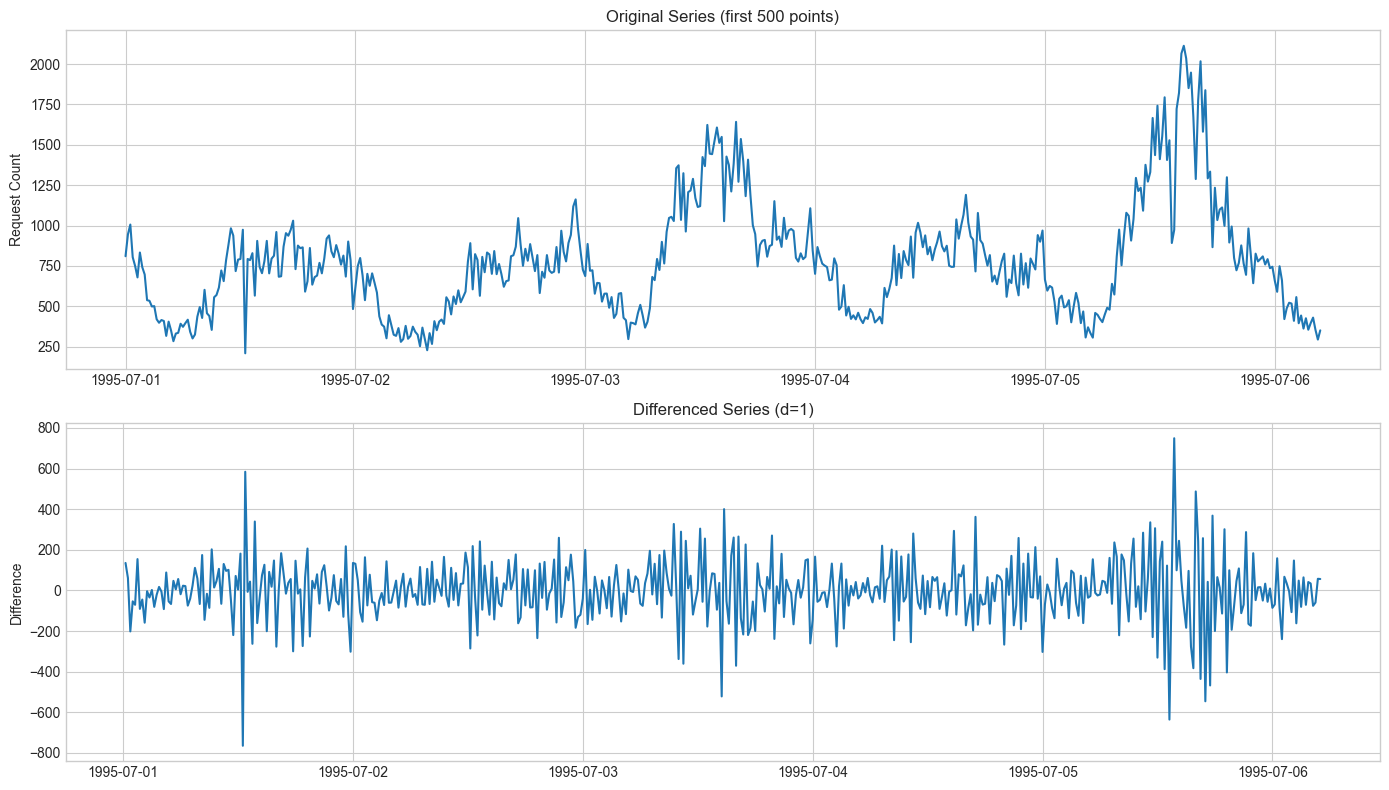

In [ ]:
# Visualize original vs differenced series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original
axes[0].plot(train_series.index[:500], train_series.values[:500])
axes[0].set_title('Original Series (first 500 points)')
axes[0].set_ylabel('Request Count')

# Differenced
diff_series = train_series.diff().dropna()
axes[1].plot(diff_series.index[:500], diff_series.values[:500])
axes[1].set_title('Differenced Series (d=1)')
axes[1].set_ylabel('Difference')

plt.tight_layout()
plt.savefig('../reports/figures/sarima_stationarity.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. ACF và PACF Analysis

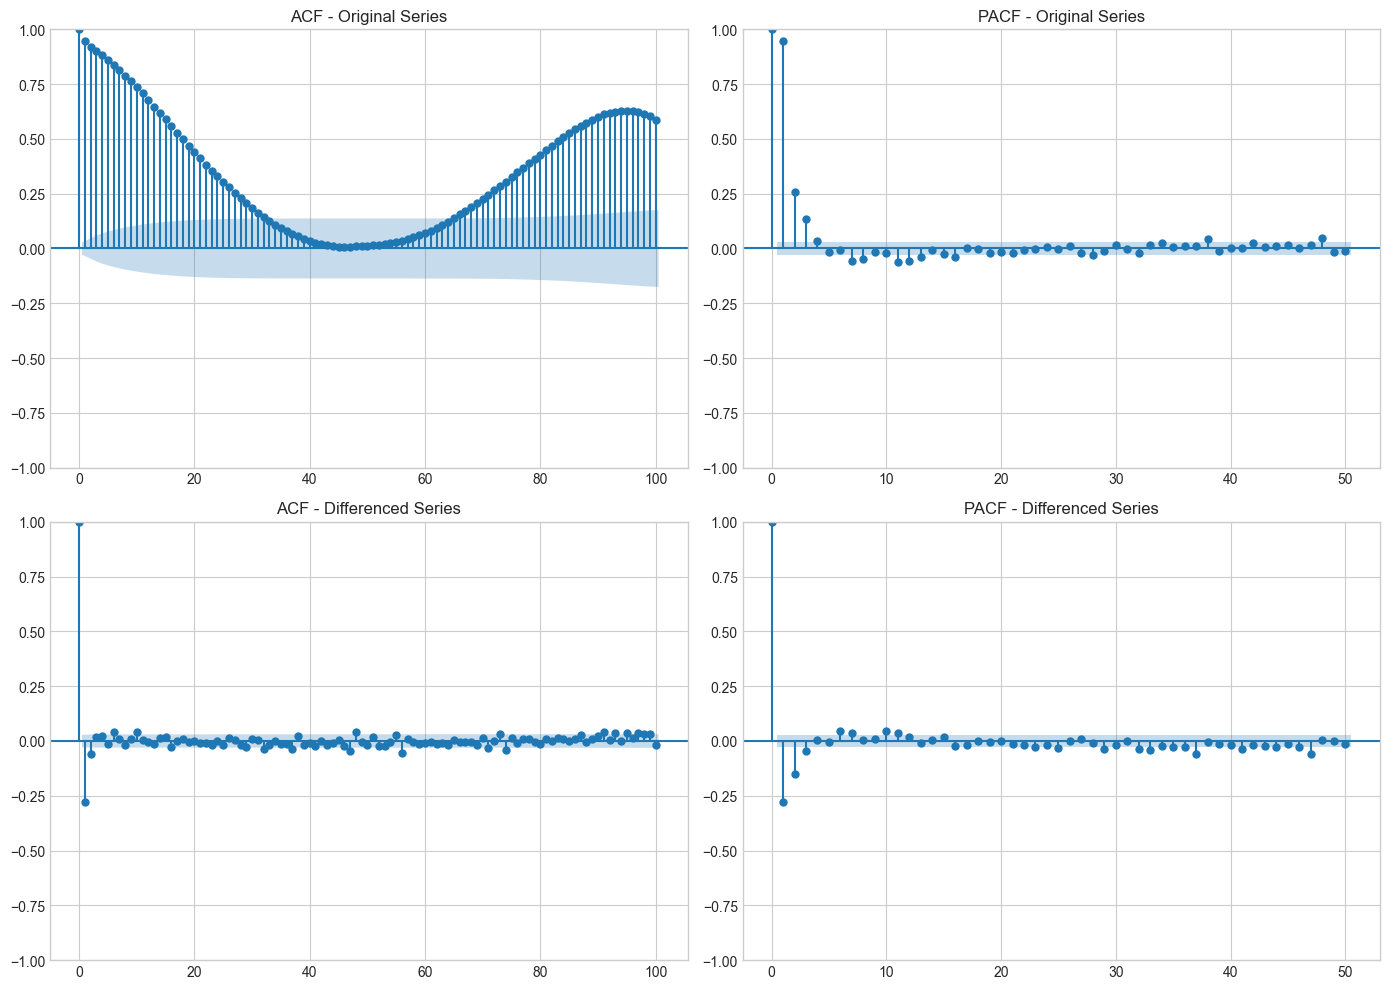

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ACF of original
plot_acf(train_series.dropna(), lags=100, ax=axes[0, 0], title='ACF - Original Series')

# PACF of original
plot_pacf(train_series.dropna(), lags=50, ax=axes[0, 1], title='PACF - Original Series')

# ACF of differenced
plot_acf(diff_series.dropna(), lags=100, ax=axes[1, 0], title='ACF - Differenced Series')

# PACF of differenced
plot_pacf(diff_series.dropna(), lags=50, ax=axes[1, 1], title='PACF - Differenced Series')

plt.tight_layout()
plt.savefig('../reports/figures/sarima_acf_pacf.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Fit SARIMA Model

In [ ]:
# SARIMA với recommended parameters cho 15-min data
# seasonal_order = (1,1,1,96) vì 96 intervals = 24 hours (daily seasonality)

model = SARIMAForecaster(
    order=(2, 1, 2),
    seasonal_order=(1, 1, 0, 96)
)

print("Training SARIMA model...")
print("This may take a few minutes...")
model.fit(train_series, verbose=True)

Training SARIMA model...
This may take a few minutes...
Fitting SARIMA(2, 1, 2)x(1, 1, 0, 96)...
  Training samples: 4,937


In [ ]:
# Model summary
model.summary()

In [ ]:
# Model diagnostics
diagnostics = model.get_diagnostics()
print("\nModel Diagnostics:")
print("="*50)
print(f"  AIC: {diagnostics['aic']:.2f}")
print(f"  BIC: {diagnostics['bic']:.2f}")
print(f"  Log-likelihood: {diagnostics['llf']:.2f}")
print(f"  Residual Mean: {diagnostics['residual_mean']:.4f}")
print(f"  Residual Std: {diagnostics['residual_std']:.4f}")

## 5. Generate Forecasts

In [ ]:
# Forecast cho test period
predictions = model.predict(
    steps=len(test_series),
    return_conf_int=True,
    alpha=0.05  # 95% confidence interval
)

print(f"Predictions shape: {predictions.shape}")
predictions.head(10)

In [ ]:
# Visualize predictions vs actual
fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual
ax.plot(test_series.index, test_series.values, label='Actual', alpha=0.8)

# Plot forecast
pred_index = test_series.index[:len(predictions)]
ax.plot(pred_index, predictions['forecast'].values, label='SARIMA Forecast', alpha=0.8, linestyle='--')

# Confidence interval
ax.fill_between(
    pred_index,
    predictions['lower'].values,
    predictions['upper'].values,
    alpha=0.2,
    label='95% CI'
)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Request Count')
ax.set_title('SARIMA Forecast vs Actual (Test Set)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/sarima_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Evaluate Model

In [ ]:
# Calculate metrics
y_true = test_series.values[:len(predictions)]
y_pred = predictions['forecast'].values

metrics = calculate_metrics(y_true, y_pred)

print("\nSARIMA Model Metrics:")
print("="*50)
for name, value in metrics.items():
    print(f"  {name}: {value:.4f}")

In [ ]:
# Forecast accuracy analysis
accuracy = calculate_forecast_accuracy(y_true, y_pred, threshold_pct=20)

print("\nForecast Accuracy Analysis:")
print("="*50)
print(f"  Accuracy within 20%: {accuracy['accuracy_within_threshold']:.2f}%")
print(f"  Mean Error: {accuracy['mean_error']:.2f}")
print(f"  Mean % Error: {accuracy['mean_pct_error']:.2f}%")
print(f"  Max Over-prediction: {accuracy['max_overpredict']:.2f}")
print(f"  Max Under-prediction: {accuracy['max_underpredict']:.2f}")

In [ ]:
# Error distribution
errors = y_pred - y_true

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error histogram
axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='Zero Error')
axes[0].axvline(x=errors.mean(), color='green', linestyle='--', label=f'Mean: {errors.mean():.2f}')
axes[0].set_title('Forecast Error Distribution')
axes[0].set_xlabel('Error (Predicted - Actual)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Predicted vs Actual scatter
axes[1].scatter(y_true, y_pred, alpha=0.5, s=10)
max_val = max(y_true.max(), y_pred.max())
axes[1].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Predicted vs Actual')
axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/sarima_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Residual Analysis

In [ ]:
# Get residuals
residuals = model.get_residuals()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residual plot
axes[0, 0].plot(residuals.index, residuals.values, alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals over Time')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')

# Histogram
axes[0, 1].hist(residuals.dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')

# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.dropna(), lags=50, ax=axes[1, 0], title='ACF of Residuals')

# QQ plot
from scipy import stats
stats.probplot(residuals.dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.tight_layout()
plt.savefig('../reports/figures/sarima_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Save Model

In [ ]:
# Save the trained model
model.save('../models/sarima_15min.pkl')
print("Model saved successfully!")

In [ ]:
# Test loading
loaded_model = SARIMAForecaster.load('../models/sarima_15min.pkl')
print(f"Model loaded: order={loaded_model.order}, seasonal={loaded_model.seasonal_order}")

## 9. Summary

In [ ]:
print("="*60)
print("              SARIMA MODEL SUMMARY")
print("="*60)
print(f"\nModel: SARIMA{model.order}x{model.seasonal_order}")
print(f"Granularity: 15 minutes")
print(f"\nTraining Data:")
print(f"  Samples: {len(train_series)}")
print(f"  Period: {train.index.min()} to {train.index.max()}")
print(f"\nTest Data:")
print(f"  Samples: {len(test_series)}")
print(f"  Period: {test.index.min()} to {test.index.max()}")
print(f"\nModel Performance:")
print(f"  RMSE: {metrics['RMSE']:.2f} requests/interval")
print(f"  MAE: {metrics['MAE']:.2f} requests/interval")
print(f"  MAPE: {metrics['MAPE']:.2f}%")
print(f"\nModel Fit:")
print(f"  AIC: {diagnostics['aic']:.2f}")
print(f"  BIC: {diagnostics['bic']:.2f}")
print(f"\nSaved to: ../models/sarima_15min.pkl")
print("="*60)

## 10. bytes_total Forecasting

Train SARIMA on bytes_total (total bytes transferred) as a second target variable.

In [ ]:
# Prepare bytes_total data
train_bytes = train['bytes_total']
test_bytes = test['bytes_total']

print(f"bytes_total statistics:")
print(f"  Train mean: {train_bytes.mean():,.0f} bytes")
print(f"  Train std: {train_bytes.std():,.0f} bytes")
print(f"  Test mean: {test_bytes.mean():,.0f} bytes")

In [ ]:
# Train SARIMA on bytes_total
print("Training SARIMA on bytes_total...")
print("="*50)

model_bytes = SARIMAForecaster(
    order=(2, 1, 2),
    seasonal_order=(1, 1, 0, 96)  # Using (1,1,0,96) to avoid memory issues
)
model_bytes.fit(train_bytes, verbose=True)

In [ ]:
# Forecast bytes_total
predictions_bytes = model_bytes.predict(
    steps=len(test_bytes),
    return_conf_int=True,
    alpha=0.05
)

print(f"Predictions shape: {predictions_bytes.shape}")

In [ ]:
# Visualize bytes_total predictions
fig, ax = plt.subplots(figsize=(14, 6))

pred_index_bytes = test_bytes.index[:len(predictions_bytes)]
ax.plot(test_bytes.index, test_bytes.values, label='Actual', alpha=0.8)
ax.plot(pred_index_bytes, predictions_bytes['forecast'].values, label='SARIMA Forecast', alpha=0.8, linestyle='--')

ax.fill_between(
    pred_index_bytes,
    predictions_bytes['lower'].values,
    predictions_bytes['upper'].values,
    alpha=0.2,
    label='95% CI'
)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Bytes Total')
ax.set_title('SARIMA Forecast - bytes_total (Test Set)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/sarima_bytes_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Calculate metrics for bytes_total
y_true_bytes = test_bytes.values[:len(predictions_bytes)]
y_pred_bytes = predictions_bytes['forecast'].values

metrics_bytes = calculate_metrics(y_true_bytes, y_pred_bytes)

print("\nSARIMA bytes_total Metrics:")
print("="*50)
for name, value in metrics_bytes.items():
    print(f"  {name}: {value:.4f}")

In [ ]:
# Save bytes_total model
model_bytes.save('../models/sarima_bytes_15min.pkl')
print("bytes_total model saved to: ../models/sarima_bytes_15min.pkl")

In [ ]:
# Comparison summary
print("="*60)
print("        SARIMA MODEL COMPARISON: request_count vs bytes_total")
print("="*60)
print(f"\n{'Target':<20} {'RMSE':<15} {'MAE':<15} {'MAPE':<15}")
print("-"*60)
print(f"{'request_count':<20} {metrics['RMSE']:<15.2f} {metrics['MAE']:<15.2f} {metrics['MAPE']:.2f}%")
print(f"{'bytes_total':<20} {metrics_bytes['RMSE']:<15.2f} {metrics_bytes['MAE']:<15.2f} {metrics_bytes['MAPE']:.2f}%")
print("="*60)